## Problem statement

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_{\inf}}{T_{b} - T_{{\inf}}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_{\inf})}$


- $\epsilon_G=\epsilon(T_b-T_{\inf})$


- $\epsilon_C=\beta(T_b-T_{\inf})$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$


**Given a sample which contains 9 values of $x$ and $\theta$ predict $G$** 

## Import libraries 

In [2]:
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

## Hyper-parameters

In [69]:
device = 'cpu'
print('Device employed:', device)
seed_id = 7623
# la 0,1, 2, 50 y la 250 andan
#  la seed 7623 = data 395 No anda 
# la 565 anda y tiene derivada segunda positiva pero el G da negatvio
steps = 30000
lr = 4e-3
nneurons = 20
nhiden_layers = 8
N_f = 40 #Total number of collocation points 
offset = .0001
G_init = 1.
N = 1.
ec = .4
eg = .6
print("Our initial guess of G is: G_PINN= [",G_init,"]")
print("The other parameters are: N= [",N,"], ec= [",ec,"], eg= [",eg,"]")

Device employed: cpu
Our initial guess of G is: G_PINN= [ 1.0 ]
The other parameters are: N= [ 1.0 ], ec= [ 0.4 ], eg= [ 0.6 ]


## Set random seed and select device

In [67]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(seed_id)

# Random number generators in other libraries
np.random.seed(seed_id)

## Load data

In [58]:
###### Load dataset
relative_csv_path = "./../src/data/raw/heat_transfer_finn.csv"

# Load a random sample
fields_G = ['G']
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields = fields_T + fields_G
data = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
random_sample = data.sample()
print('The data used is form the sample:',random_sample.index[0])
G_real = random_sample[fields_G].to_numpy()
T_real = random_sample[fields_T].to_numpy().T
X_real = np.linspace(0,1,T_real.shape[0]).reshape(-1,1)
X_real = X_real.astype(np.float32)
X_bc = X_real[-1].reshape(-1,1)

# compute theta 
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_real = np.multiply(np.add(T_real, [-T_inf]), [1/(T_b - T_inf)])
Theta_real = Theta_real.astype(np.float32)
Theta_real = torch.from_numpy(Theta_real)
# prin shapes 
print('G_real is:',G_real)

# lower and uper bounds to normalize the input of net U
lb = min(X_real)
ub = max(X_real)
N_u = Theta_real.shape[0]

The data used is form the sample: 395
G_real is: [[0.32634646]]


### Collocation points ($loss_f$)

In [59]:
f_hat = torch.zeros(N_f,1).to(device)
theta_x_hat = torch.zeros(1,1).to(device)
G_hat = torch.zeros(1,1).to(device)
print("The number of collocation points are", N_f)
X_train_f = torch.linspace(lb[0] + offset, ub[0] - offset,N_f).reshape(-1,1)

The number of collocation points are 40


## Define architecture 

In [60]:
input_dim = X_real.shape[1]
output_dim = Theta_real.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])
print("The number of layers selected are", layers.size-1)
print("The number of neurons per layer are", layers)

The number of layers selected are 9
The number of neurons per layer are [ 1 20 20 20 20 20 20 20 20  1]


## Deep NN class

In [61]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
            
        #convert to float
        a = x.float()

        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## PINN class

In [68]:
class PINN():
    def __init__(self, layers):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='sum')
        
        'Initialize iterator'
        self.iter = 0
        
        'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        self.G = torch.tensor([float(G_init)], requires_grad=True).float().to(device)  
                
        'Register parametes to be optimized'
        self.G = nn.Parameter(self.G)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        'Register our new parameter'
        self.dnn.register_parameter('G', self.G)  

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "G": [],
                             "Total":[]}
        
        'Parameters trials'
        self.params_history = {"G": []}

    def loss_data(self, x, theta_real, save = False):
                   
        if torch.is_tensor(theta_real) != True:         
            theta_real = torch.from_numpy(theta_real)
        
        theta_nn = self.dnn(x)
        loss_d = self.loss_function(theta_nn, theta_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, x_f, save = False):
                   
        # extract the PDE parameters
        G = self.G

        # clone the input data and add AD
        x = x_f.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        # copmute term to be derived
        aux = (1 + ec * theta) * theta_x

        aux_x = autograd.grad(aux, x, torch.ones(x_f.shape).to(device), create_graph=True)[0]
        
        # PDE f  = 0
        f = aux_x - N**2*theta + N**2*G*(1 + eg*theta)   

        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f, f_hat)
        
        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 

        return loss_f
    
    def loss_BC(self,x_bc, save = False):
        
        if torch.is_tensor(x_bc) != True:         
            x_bc = torch.from_numpy(x_bc)

        # clone the input data and add AD
        x = x_bc.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_bc.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        loss_bc = self.loss_function(theta_x, theta_x_hat)
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc
    
    def loss_G(self, save = False):
        G_corrected = 0.0
        G_NN = self.G
        if G_NN < 1e-5:
            K = 1000
            G_corrected = K * G_NN**2
        
        G_corrected = torch.Tensor([G_corrected]).to(device)
        lossG = self.loss_function(G_corrected, G_hat)
            
        save and self.loss_history["G"].append(lossG.to('cpu').detach().numpy())
                
        return lossG
        
    def loss(self, x_real, theta_real, x_f, x_bc, save = False):

        loss_d  = self.loss_data(x_real, theta_real, save)
        loss_f  = self.loss_PDE(x_f, save)
        loss_bc = self.loss_BC(x_bc, save)
        loss_g = self.loss_G(save)
        
        # weights should sum 1
        loss_val = loss_d + loss_f + loss_bc + loss_g
        # loss_val = loss_d + loss_f + loss_bc 
        if save:
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
            self.params_history["G"].append(self.G.to('cpu').data.numpy().copy())
            
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optim.optimizer.zero_grad()
        
        loss = self.loss(X_real, Theta_real, X_train_f, X_bc, True)
        
        loss.backward()
        
        self.iter += 1

        if self.iter % 50 == 0:
            print(
                'LBFGS iter: %d, Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.5f]' %
                (
                    self.iter,
                    loss.cpu().detach().numpy(),
                    G_real,
                    self.G.item(),
                )
            )

        
        return loss        
    
    'foward pass'
    def forward(self,x):
        return self.dnn(x)
    
    'test neural network with the norm '
    def test(self):
                
        theta_pred = self.dnn(X_real)
        # Relative L2 Norm of the error (Vector)
        error_vec = torch.linalg.norm((Theta_real - theta_pred),2)/torch.linalg.norm(Theta_real,2)  
        theta_pred = theta_pred.cpu().detach().numpy()
                        
        return error_vec, theta_pred

## Train the model with Adam


In [70]:
'Neural Network Summary'
pinn_adam = PINN(layers)

'Neural Network Parameters'
params = list(pinn_adam.dnn.parameters())

'ADAM Optimizer'
optimizer = torch.optim.Adam(params, lr, 
                             amsgrad = True)


'Train the model'
for epoch in range(steps):
    # compute net U prediction
    theta_nn = pinn_adam.dnn(X_real)
    loss = pinn_adam.loss(X_real, Theta_real, X_train_f, X_bc, True)
    if epoch%(steps/100) == 0:
        print(
        'Epoch: %d, Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.6f]' %
            (
            epoch,
            loss.cpu().detach().numpy(),
            G_real,
            pinn_adam.G.item(),
            )
        )
    # increment the counter 
    pinn_adam.iter +=1 
    # update parameters
    optimizer.zero_grad()       # Zero Out the gradient
    loss.backward()    
    optimizer.step()
    
    test_error, _ = pinn_adam.test()


/home/mvanzulli/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss error(Train): 107.6037216187 , G_real = [0.32635], G_PINN = [1.000000]
Epoch: 300, Loss error(Train): 0.0624554120 , G_real = [0.32635], G_PINN = [0.892943]
Epoch: 600, Loss error(Train): 0.0507489443 , G_real = [0.32635], G_PINN = [0.871034]
Epoch: 900, Loss error(Train): 0.0452408344 , G_real = [0.32635], G_PINN = [0.847943]
Epoch: 1200, Loss error(Train): 0.0407816544 , G_real = [0.32635], G_PINN = [0.824153]
Epoch: 1500, Loss error(Train): 0.0367254540 , G_real = [0.32635], G_PINN = [0.800421]
Epoch: 1800, Loss error(Train): 0.0330261849 , G_real = [0.32635], G_PINN = [0.777281]
Epoch: 2100, Loss error(Train): 0.0296862014 , G_real = [0.32635], G_PINN = [0.755060]
Epoch: 2400, Loss error(Train): 0.0266958140 , G_real = [0.32635], G_PINN = [0.733943]
Epoch: 2700, Loss error(Train): 0.0240344964 , G_real = [0.32635], G_PINN = [0.714027]
Epoch: 3000, Loss error(Train): 0.0216765255 , G_real = [0.32635], G_PINN = [0.695355]
Epoch: 3300, Loss error(Train): 0.0195938367 , 

# Losses vs num epochs 

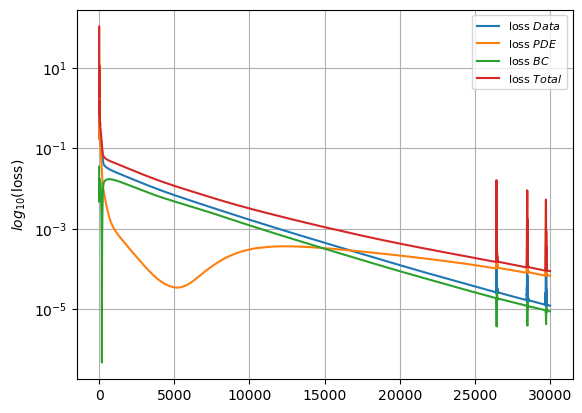

In [71]:
plt.cla()
plt.plot(pinn_adam.loss_history["Data"] , label = r'loss $Data$')
plt.plot(pinn_adam.loss_history["PDE"] , label = r'loss $PDE$')
plt.plot(pinn_adam.loss_history["BC"] , label = r'loss $BC$')
plt.plot(pinn_adam.loss_history["Total"] , label = r'loss $Total$')

plt.legend(loc='upper right', prop={'size': 8})
# plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

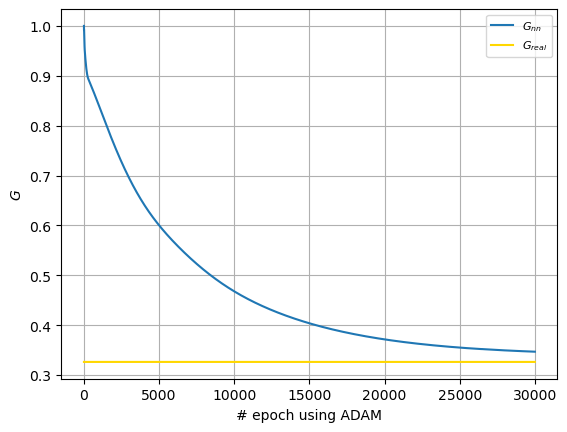

In [72]:
plt.cla()
plt.plot(range(steps), pinn_adam.params_history["G"], label = r'$G_{nn}$')
plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch using ADAM')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")

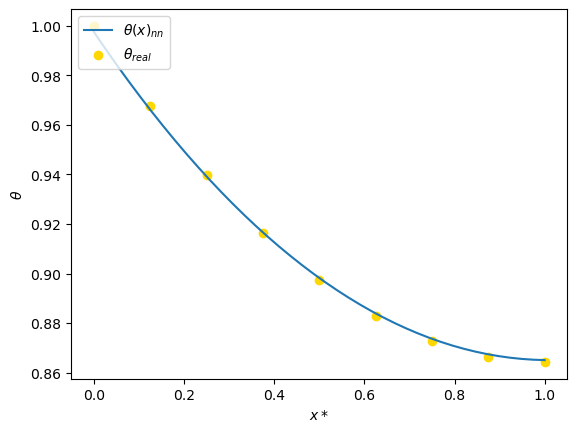

In [12]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn_adam.forward(X_train_f).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_f, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')

plt.xlabel('$x*$')
plt.ylabel(r'$\theta$')
plt.legend(loc='upper left', prop={'size': 10})

## Train with LBFGS

In [37]:
'Neural Network Summary'
pinn_LBFGS = PINN(layers)

'Neural Network Parameters'
params = list(pinn_LBFGS.dnn.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-20, 
                              tolerance_change = 1e-20, 
                              line_search_fn = 'strong_wolfe',
                              history_size = 100)

optimizer.step(pinn_LBFGS.closure)

LBFGS iter: 50, Loss error(Train): 0.4478126466 , G_real = [0.32635], G_PINN = [0.92423]
LBFGS iter: 100, Loss error(Train): 0.0241913293 , G_real = [0.32635], G_PINN = [0.67005]
LBFGS iter: 150, Loss error(Train): 0.0103463586 , G_real = [0.32635], G_PINN = [0.57008]
LBFGS iter: 200, Loss error(Train): 0.0069624772 , G_real = [0.32635], G_PINN = [0.52272]
LBFGS iter: 250, Loss error(Train): 0.0044110836 , G_real = [0.32635], G_PINN = [0.49340]
LBFGS iter: 300, Loss error(Train): 0.0018428715 , G_real = [0.32635], G_PINN = [0.41910]
LBFGS iter: 350, Loss error(Train): 0.0001010129 , G_real = [0.32635], G_PINN = [0.35113]


tensor(42.1048, grad_fn=<AddBackward0>)

# Losses vs num epochs 

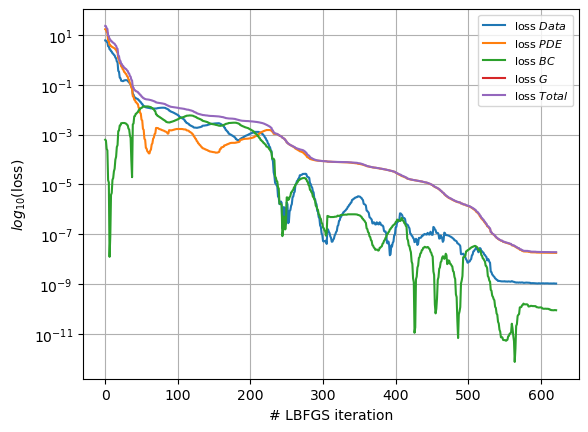

In [35]:
plt.cla()
plt.plot(pinn_LBFGS.loss_history["Data"] , label = r'loss $Data$')
plt.plot(pinn_LBFGS.loss_history["PDE"] , label = r'loss $PDE$')
plt.plot(pinn_LBFGS.loss_history["BC"] , label = r'loss $BC$')
plt.plot(pinn_LBFGS.loss_history["G"] , label = r'loss $G$')
plt.plot(pinn_LBFGS.loss_history["Total"] , label = r'loss $Total$')

plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('# LBFGS iteration')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

## PDE Parameters ($G$) value vs num epochs

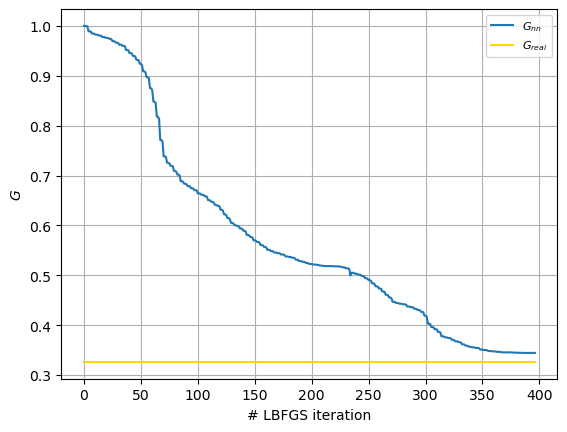

In [38]:
plt.cla()
LBFGS_steps = len(pinn_LBFGS.params_history["G"])
plt.plot(pinn_LBFGS.params_history["G"] ,label = r'$G_{nn}$')
plt.plot(range(LBFGS_steps), G_real*np.ones((LBFGS_steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# LBFGS iteration')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")

##  Plot $\theta(x)$ solution

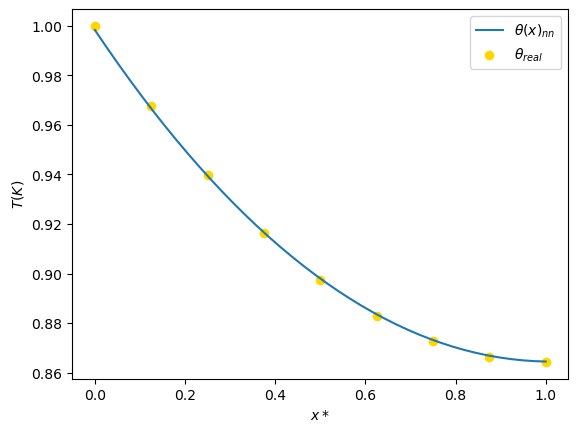

In [39]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn_LBFGS.forward(X_train_f).to('cpu').detach().numpy()

plt.cla()
plt.plot(x_f, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')

plt.xlabel('$x*$')
plt.ylabel('$T(K)$')
plt.legend(loc='best', prop={'size': 10})


## Make some noise! 

In [12]:
alpha = [0.05, 0.1, 0.2 ]

In [48]:
deviation_T =  T_real.std()
loss_evol = np.zeros((len(alpha), steps))
G_evol = np.zeros((len(alpha), steps))
theta_list = []

for i, alpha_dev in enumerate(alpha):   
    noise_dev_std = deviation_T * alpha_dev 
    T_real_noisy = torch.from_numpy(T_real) 
    noise_T = torch.normal(0, noise_dev_std, T_real.shape)
    T_real_noisy += noise_T
    Theta_noisy = torch.multiply(torch.add(T_real_noisy, torch.tensor([-T_inf])), torch.tensor([1/(T_b - T_inf)]))
    # Hardcode the dirichlet bc value 
    Theta_noisy[0] = 1.0
    Theta_noisy = Theta_noisy.type(torch.Tensor)

    'Neural Network Summary'
    pinn_noisy_variable = PINN(layers)

    'Neural Network Parameters'
    params = list(pinn_noisy_variable.dnn.parameters())

    'ADAM Optimizer'
    optimizer = torch.optim.Adam(params, lr, 
                                amsgrad = True)

    'Train the model'
    for epoch in range(steps):
        # compute net U prediction
        theta_nn = pinn_noisy_variable.dnn(X_real)
        # compute losses
        loss = pinn_noisy_variable.loss(X_real, Theta_noisy, X_train_f,X_bc, True)
        if epoch%(steps/100) == 0:
            print(
            'Epoch: %d, Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.6f], alpha: %.2f' %
                (
                epoch,
                loss.cpu().detach().numpy(),
                G_real,
                pinn_noisy_variable.G.item(),
                alpha_dev,
                )
            )
        # update parameters
        optimizer.zero_grad()       # Zero Out the gradient
        loss.backward()    
        optimizer.step()
        loss_evol[i, epoch] = loss.cpu().detach().numpy()
        G_evol[i, epoch] = pinn_noisy_variable.G.item()

    # Compute theta nn
    theta_nn = pinn_noisy_variable.forward(X_train_f).to('cpu').detach().numpy()
    theta_list.append(theta_nn)
    

Epoch: 0, Loss error(Train): 47.5668869019 , G_real = [0.32635], G_PINN = [1.000000], alpha: 0.05
Epoch: 100, Loss error(Train): 0.2749065757 , G_real = [0.32635], G_PINN = [0.928147], alpha: 0.05
Epoch: 200, Loss error(Train): 0.1197924688 , G_real = [0.32635], G_PINN = [0.894814], alpha: 0.05
Epoch: 300, Loss error(Train): 0.0701704025 , G_real = [0.32635], G_PINN = [0.874614], alpha: 0.05
Epoch: 400, Loss error(Train): 0.0589012578 , G_real = [0.32635], G_PINN = [0.861924], alpha: 0.05
Epoch: 500, Loss error(Train): 0.0565277562 , G_real = [0.32635], G_PINN = [0.851686], alpha: 0.05
Epoch: 600, Loss error(Train): 0.0545664541 , G_real = [0.32635], G_PINN = [0.841502], alpha: 0.05
Epoch: 700, Loss error(Train): 0.0525751635 , G_real = [0.32635], G_PINN = [0.830989], alpha: 0.05
Epoch: 800, Loss error(Train): 0.0505732633 , G_real = [0.32635], G_PINN = [0.820205], alpha: 0.05
Epoch: 900, Loss error(Train): 0.0485812649 , G_real = [0.32635], G_PINN = [0.809238], alpha: 0.05
Epoch: 1000

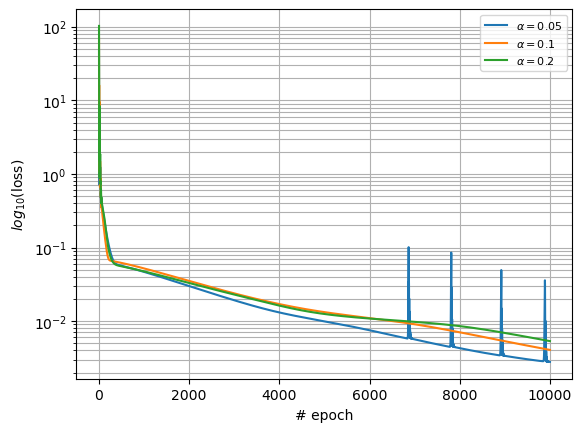

In [49]:
# Plot every row of loss_evol
plt.cla()
for i in range(len(alpha)):
    plt.plot(loss_evol[i,:], label = r'$\alpha = $' + str(alpha[i]))
plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()




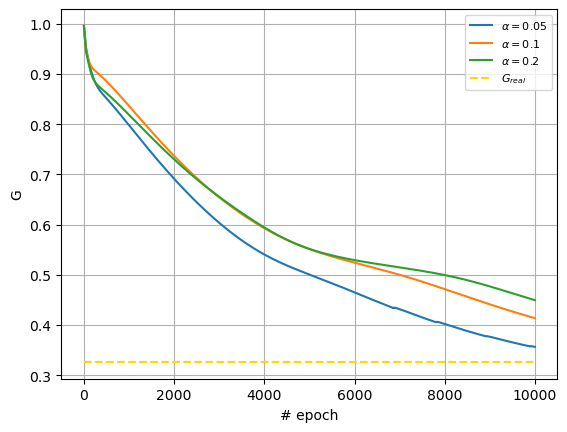

In [50]:
# Plot every row of G_evol
plt.cla()
for i in range(len(alpha)):
    plt.plot(G_evol[i,:], label = r'$\alpha = $' + str(alpha[i]))
# Plot G_real with dashed line
plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold', ls = '--')
plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel('G')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()


In [45]:
theta_list[0].reshape(-1,).shape
x_f.shape
len(theta_list)

3

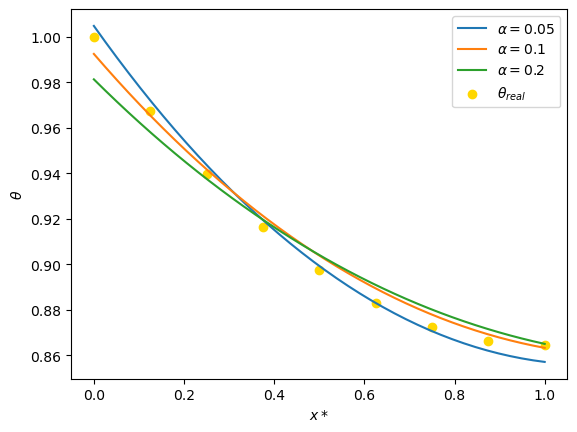

In [51]:
# Compute theta values for every pinn_noisy
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()

# Plot every row of theta_nn_noisy
plt.cla()
for i in range(len(alpha)):
    theta_case = theta_list[i].reshape(-1,)
    plt.plot(x_f, theta_case, label = r'$\alpha = $' + str(alpha[i]))
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')
plt.xlabel('$x*$')
plt.ylabel(r'$\theta$')
plt.legend(loc='best', prop={'size': 10})
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()
